In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from matplotlib.patches import Circle
import matplotlib.patheffects as path_effects
import os
import pickle
from scipy.stats import mannwhitneyu, ttest_ind, kruskal, f_oneway
from statannotations.Annotator import Annotator
from itertools import combinations
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import clear_output, display
import sys
sys.path.append('../scripts') 
from functions import *
from config import nutrient_info, conversion_factors, origin_map
%load_ext autoreload
%autoreload 2

In [2]:
df_food = pd.read_csv('../data/df_food_filtered_with_food_group.csv')
df_food_scaled = pd.read_csv('../data/df_food_scaled.csv')
df_food_clean_scaled = pd.read_csv('../data/df_food_clean_scaled.csv')

C:\Users\Sophie\AppData\Local\Temp\ipykernel_19932\1308445948.py:1: DtypeWarning: Columns (2,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food = pd.read_csv('../data/df_food_filtered_with_food_group.csv')
C:\Users\Sophie\AppData\Local\Temp\ipykernel_19932\1308445948.py:2: DtypeWarning: Columns (1,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food_scaled = pd.read_csv('../data/df_food_scaled.csv')
C:\Users\Sophie\AppData\Local\Temp\ipykernel_19932\1308445948.py:3: DtypeWarning: Columns (2,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food_clean_scaled = pd.read_csv('../data/df_food_clean_scaled.csv')


In [3]:
qualifying_nutrients = {nutr: info for nutr, info in nutrient_info.items() if info['type'] == 'qualifying'}
disqualifying_nutrients = {nutr: info for nutr, info in nutrient_info.items() if info['type'] == 'disqualifying'}

qualifying_list   = list(qualifying_nutrients.keys())
disqualifying_list = list(disqualifying_nutrients.keys())

In [24]:
mean_qi_per_nutrient = df_food_clean_scaled[qualifying_list].mean()
most_limiting_qi_nutrient = mean_qi_per_nutrient.sort_values().head(5)
print('Top 5 worst performing nutrient for QI :')
print(most_limiting_qi_nutrient)

Top 5 worst performing nutrient for QI :
vitamin_d_eaten      1.691556e-07
vitamin_b12_eaten    2.164670e-07
folate_eaten         1.159829e-05
vitamin_b1_eaten     5.700165e-05
vitamin_b2_eaten     6.619915e-05
dtype: float64


In [25]:
mean_di_per_nutrient = df_food_clean_scaled[disqualifying_list].mean()
most_driving_di_nutrient = mean_di_per_nutrient.sort_values(ascending=False).head(5)
print('Top 5 most excessive problematic nutrient for DI :')
print(most_driving_di_nutrient)

Top 5 most excessive problematic nutrient for DI :
fat_eaten                      5.920416
sugar_eaten                    5.556737
fatty_acids_saturated_eaten    2.135632
salt_eaten                     0.364183
sodium_eaten                   0.225009
dtype: float64


C:\Users\Sophie\AppData\Local\Temp\ipykernel_19932\2114558362.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


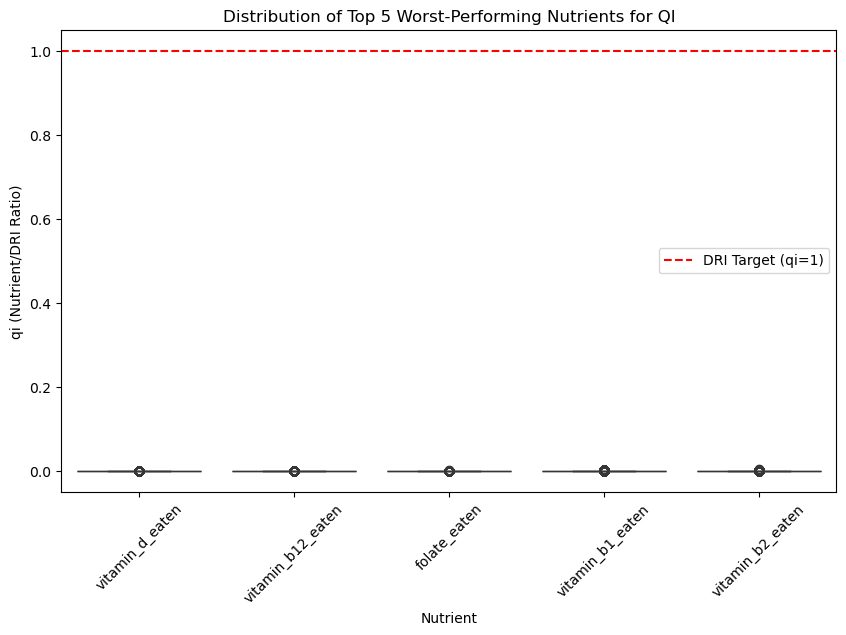

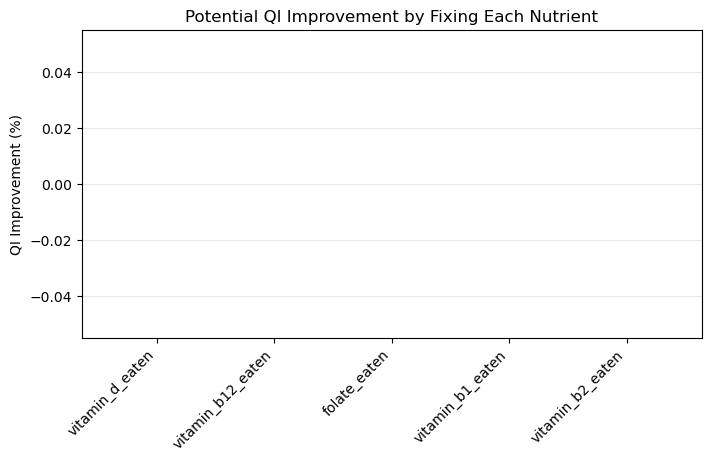

In [26]:
top5_qi = most_limiting_qi_nutrient

# Plot their distribution
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_food_clean_scaled.melt(value_vars=top5_qi.index, var_name='Nutrient', value_name='qi'),
    x='Nutrient',
    y='qi',
    palette='Blues'
)
plt.axhline(y=1, color='red', linestyle='--', label='DRI Target (qi=1)')
plt.title('Distribution of Top 5 Worst-Performing Nutrients for QI')
plt.ylabel('qi (Nutrient/DRI Ratio)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Simulate QI improvement if fixing deficiencies
original_qi = df_food_clean_scaled['QI'].mean()
improved_qi = []

for nutrient in top5_qi.index:
    # Create "fixed" version where this nutrient reaches qi=1
    temp_df = df_food_clean_scaled.copy()
    temp_df[nutrient] = temp_df[nutrient].clip(lower=1) 
    improved_qi.append(temp_df['QI'].mean())

plt.figure(figsize=(8, 4))
plt.bar(
    x=top5_qi.index,
    height=[(iq - original_qi)/original_qi*100 for iq in improved_qi],
    color='green'
)
plt.title('Potential QI Improvement by Fixing Each Nutrient')
plt.ylabel('QI Improvement (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.show()

C:\Users\Sophie\AppData\Local\Temp\ipykernel_19932\1850705280.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


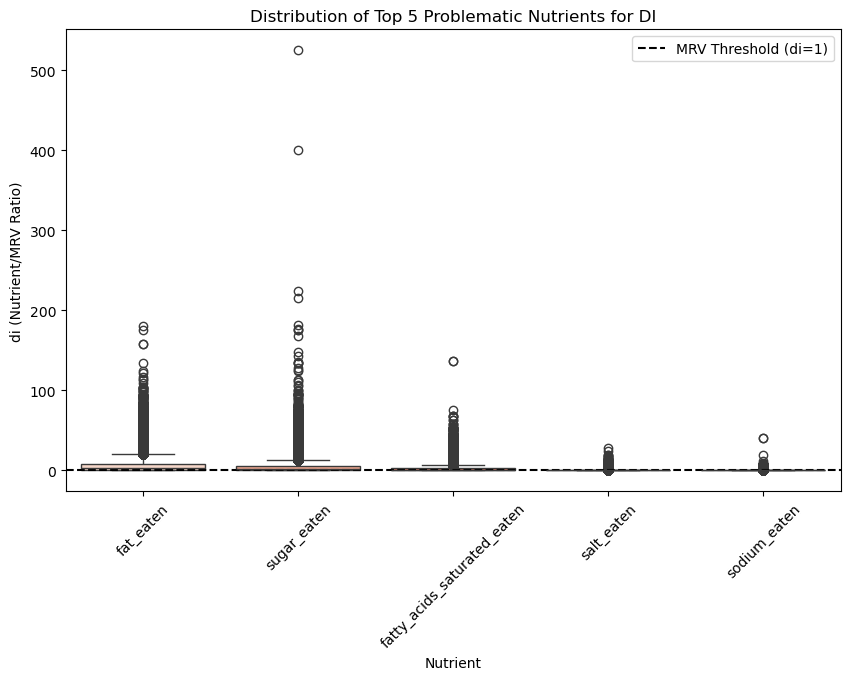

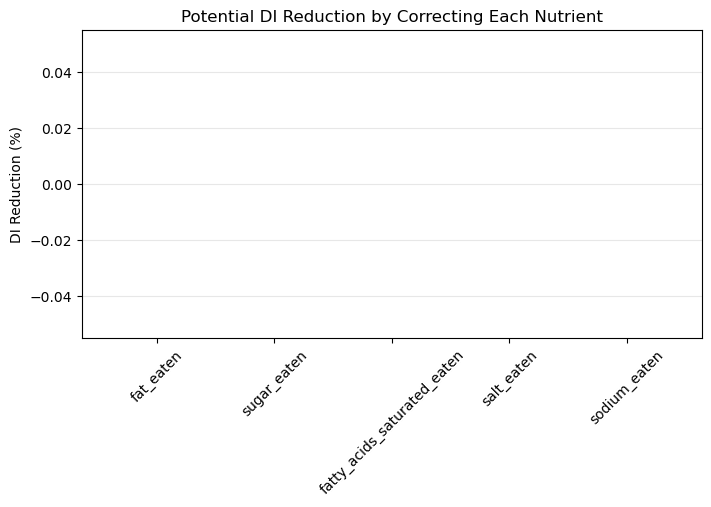

In [23]:
# Get top 5 excessive nutrients
top5_di = most_driving_di_nutrient

# Plot their prevalence
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_food_scaled.melt(value_vars=top5_di.index, var_name='Nutrient', value_name='di'),
    x='Nutrient',
    y='di',
    palette='Reds'
)
plt.axhline(y=1, color='black', linestyle='--', label='MRV Threshold (di=1)')
plt.title('Distribution of Top 5 Problematic Nutrients for DI')
plt.ylabel('di (Nutrient/MRV Ratio)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Simulate DI reduction
original_di = df_food_scaled['DI'].mean()
improved_di = []

for nutrient in top5_di.index:
    # Create "fixed" version where this nutrient reaches di=1
    temp_df = df_food_scaled.copy()
    temp_df[nutrient] = temp_df[nutrient].clip(upper=1)
    improved_di.append(temp_df['DI'].mean())

plt.figure(figsize=(8, 4))
plt.bar(
    x=top5_di.index,
    height=[(original_di - di)/original_di*100 for di in improved_di],
    color='orange'
)
plt.title('Potential DI Reduction by Correcting Each Nutrient')
plt.ylabel('DI Reduction (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()